# Биоразнообразие vs DHI: разведочный анализ-2

Цель документа -- визуализировать зависимости между биоразнообразием и DHI, найти типичные шаблоны в пространственном размещении.

Это документ продолжение [первой части](https://176.9.38.120/cruncher/notebooks/DHI/DHI_biodiversity.ipynb), в которой анализировался файл, содержащий DHI, рассчитанный по "сырым" данным fpar. В этом документе анализируются данные, содержащие DHI, рассчитанные по сглаженным данным.

Тут проделываются все те же действия, но на обновленых данных. **Это копия второй части, в ней используется решетка малого размера 3х5 вместо 4х7.**

## Беглый взгляд на данные

Данные хранятся в файле `DATA/wwf_globe_all_biomes_filtered_dhi.csv`, прочитаем его:

In [1]:
points = read.table('DATA/wwf_globe_all_biomes_filtered_dhi.csv', header = TRUE, sep=",")

### Описательная статистика:

Получим краткую сводку по содержанию столбцов (минимум, 1-й квартиль, медиана, среднее, 3-й квартиль и максимум):

In [2]:
summary(points)

       X                 Y                CID          AMPHIBIANS   
 Min.   :-179.87   Min.   :-55.255   Min.   :    1   Min.   :  0.0  
 1st Qu.: -62.71   1st Qu.:  1.047   1st Qu.: 7517   1st Qu.:  2.0  
 Median :  33.62   Median : 39.007   Median :15030   Median :  6.0  
 Mean   :  22.99   Mean   : 29.114   Mean   :15010   Mean   : 13.1  
 3rd Qu.: 100.18   3rd Qu.: 56.833   3rd Qu.:22527   3rd Qu.: 16.0  
 Max.   : 179.63   Max.   : 79.990   Max.   :30000   Max.   :131.0  
   BIRDS_glob      MAMMTERR_g       REPTILES_g        dhi_fpar1     
 Min.   :  3.0   Min.   :  0.00   Min.   :  0.000   Min.   :   6.0  
 1st Qu.:128.0   1st Qu.: 30.00   1st Qu.:  1.000   1st Qu.: 832.5  
 Median :188.0   Median : 45.00   Median :  5.000   Median :1441.5  
 Mean   :209.8   Mean   : 57.96   Mean   :  9.884   Mean   :1652.6  
 3rd Qu.:272.0   3rd Qu.: 68.00   3rd Qu.: 14.000   3rd Qu.:2221.0  
 Max.   :611.0   Max.   :200.00   Max.   :105.000   Max.   :4137.0  
   dhi_fpar2       dhi_fpar3      

### Описание столбцов с данными.

**Общая информация:**

Каждая строка таблицы (запись) представляет собой одну точку на поверхности Земли в которой были замеряны определенные параметры. Всего имеется 30 тысяч точек.

 * CID: Идентификатор записи.
 * X: Долгота.
 * Y: Широта.
 
**Биоразнообразие:**

 * AMPHIBIANS: Показатель, характеризующий биоразнообразие амфибий.
 * BIRDS_glob: Показатель, характеризующий биоразнообразие птиц.
 * MAMMTERR_g: Показатель, характеризующий биоразнообразие наземных млекопитающих.
 * REPTILES_g: Показатель, характеризующий биоразнообразие рептилий.

 
**Показатели продуктивности:**

Данные DHI -- специальные индексы, основанные на показателе продуктивности FPAR (Fraction of Absorbed Photosynthetically Active radiation) -- это доля солнечного излучения, поглощенного растительной биомассой, измеряется в процентах. Индексы `dhi*` расчитаны по сырым рядам dhi, индексы `avg*` - по сглаженным.

 * dhi_fpar1, avg_dhi_1: DHI для FPAR. Куммулятивная продуктивность: рассчитывается суммированием FPAR за год (интеграл).
 * dhi_fpar2, avg_dhi_2: DHI для FPAR. Минимальная продуктивность: минимальное значение FPAR за год.
 * dhi_fpar3, avg_dhi3: DHI для FPAR. Сезонность: расчитывается как отношение стандартного отклонения FPAR к его среднему значению (за год). Таким образом большая величина dhi_fpar3 означает большое колебание продутивности в течении года.
 
 
*Примечание 1.* Отсутсвующие данные из предыдущего файла по биоразнообразию уже отфильтрованы.
 
*Примечание 2.* Отсутвтующие данные для DHI из предыдущего файла уже отфильтрованы.

Построим графики парных распределений для DHI, рассчитанных по сырым и фильтрованным данным: 

In [2]:
# Небольшая выборка данных, для удобства работы. Используется для быстрой оценки, чтобы не ждать 
# результатов работы на большой выборке
pdata = points[c("dhi_fpar1", "dhi_fpar2", "dhi_fpar3", "avg_dhi_1", "avg_dhi_2", "avg_dhi_3")]
psample_ind = sample(1:length(pdata[, 1]), size=1000)
psample = points[psample_ind, ]

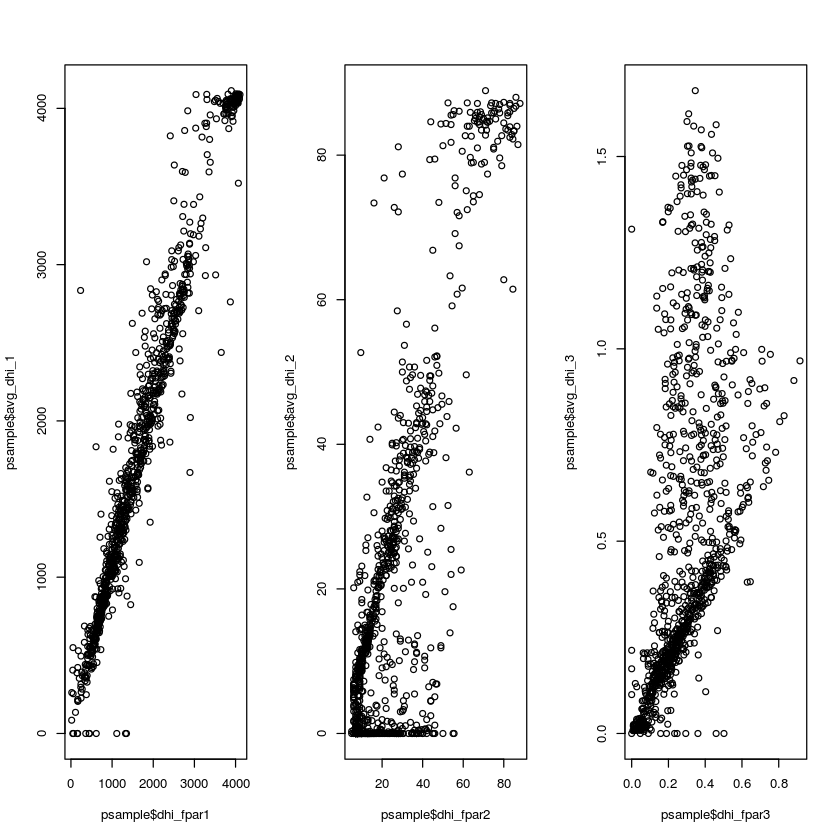

In [4]:
par(mfrow=c(1,3))
plot(psample$dhi_fpar1, psample$avg_dhi_1)
plot(psample$dhi_fpar2, psample$avg_dhi_2)
plot(psample$dhi_fpar3, psample$avg_dhi_3)

На графике видно, что в среднем куммулятивная и минимальная продуктивности в новых данных выше, а сезонность ниже. При этом часть новых данных сбросилась в ноль. Этот ноль объясняется тем, что DHI точек, попадающих в пустыни, воду, города и т.п. был насильственно сброшен до нулевого состояния (ранее они могли быть выше нуля из-за атмосферных эффектов и/или из-за естесственног ненулевого фона, например, в городах).

Выбросим старые данные DHI, а также вспомогательные поля.

In [3]:
points = points[
    c("CID", "X", "Y", "AMPHIBIANS", "BIRDS_glob", "MAMMTERR_g", 
      "REPTILES_g", "avg_dhi_1", "avg_dhi_2", "avg_dhi_3")]

# Число оставшихся точек:
length(points$X)

[1] 23269

## Исследование структуры данных

### Совместное распределение, корреляции

Итак, у нас есть набор точек, лежащих в 7-ми мерном пространстве, система координат которого состоит из семи осей: "AMPHIBIANS", "BIRDS_glob", "MAMMTERR_g", "REPTILES_g", "dhi_fpar1", "dhi_fpar2", "dhi_fpar3" (географические координаты пока не учитываем, возможно, введем их в анализ позднее). 

Построим графики взаимного расположения точек.

In [6]:
png("img/all_vars_filtered_dhi.png", width=728, height=728, units="px")
 pairs(~AMPHIBIANS+BIRDS_glob+MAMMTERR_g+REPTILES_g+avg_dhi_1+avg_dhi_2+avg_dhi_3, 
       data=points, pch = 19, cex=0.01, main="Scatterplot Matrix")
dev.off()

png 
  2

<img src="https://176.9.38.120/cruncher/files/DHI/img/all_vars_filtered_dhi.png">

По сравнению с аналогичным графиком на предыдущих данных становятся более четкими зависимости между компонентами DHI (но это, так сказать, побочный эффект).

Что же касается зависимости между биоразнообразием и DHI, то бросается в глаза, что характерные особенности (например, треугольная форма зависимостей между птицами/млекопитающими и dhi3) становятся более выраженными.

Расчитаем корреляции:

In [7]:
data_for_cor = points[
    c("AMPHIBIANS", "BIRDS_glob", "MAMMTERR_g", 
      "REPTILES_g", "avg_dhi_1", "avg_dhi_2", "avg_dhi_3")]
cor(data_for_cor)

,AMPHIBIANS,BIRDS_glob,MAMMTERR_g,REPTILES_g,avg_dhi_1,avg_dhi_2,avg_dhi_3
AMPHIBIANS,1.0000000,0.8158147,0.8386276,0.4744978,0.6541237,0.7214596,-0.4950621
BIRDS_glob,0.8158147,1.0000000,0.9091805,0.5450962,0.6620416,0.7026078,-0.6067372
MAMMTERR_g,0.8386276,0.9091805,1.0000000,0.5212821,0.6684141,0.7184224,-0.5420869
REPTILES_g,0.4744978,0.5450962,0.5212821,1.0000000,0.4755354,0.5811263,-0.5040993
avg_dhi_1,0.6541237,0.6620416,0.6684141,0.4755354,1.0000000,0.8889956,-0.5666026
avg_dhi_2,0.7214596,0.7026078,0.7184224,0.5811263,0.8889956,1.0000000,-0.6868753
avg_dhi_3,-0.4950621,-0.6067372,-0.5420869,-0.5040993,-0.5666026,-0.6868753,1.0000000


### Исследование структуры данных

Попробуем визуализировать данные методом [самоорганизующихся карт Кохонена](https://goo.gl/oc7YRl). Это позволит подробнее взглянуть на структуру и зависимости переменных.

#### Строим карту Кохонена

In [4]:
# Подключкаем библиотеку
library("kohonen")

Loading required package: class
Loading required package: MASS


Нормируем данные, чтобы все переменные вносили приблизительно равный вклад в результат.

In [5]:
pdata = points[c("AMPHIBIANS", "BIRDS_glob", "MAMMTERR_g", "REPTILES_g", "avg_dhi_1", "avg_dhi_2", "avg_dhi_3")]
pdata.sc = scale(pdata)

seed = 777      # Для того, чтобы можно было воспроизвести результаты, 
set.seed(seed)  # установим начальное значение для генератора случайных чисел

psample_ind = sample(1:length(pdata[, 1]), size=1000)
psample = points[psample_ind, ]
psample.sc = pdata.sc[psample_ind, ]

In [10]:
colSdColMeans <- function(x, na.rm=TRUE) {
  if (na.rm) {
    n <- colSums(!is.na(x)) # thanks @flodel
  } else {
    n <- nrow(x)
  }
  colVar <- colMeans(x*x, na.rm=na.rm) - (colMeans(x, na.rm=na.rm))^2
  return(sqrt(colVar * n/(n-1)))
}

avg = colMeans(pdata)
sds = colSdColMeans(pdata)

Среднее, которое будем использовать для нормировки в GRASS:

In [11]:
avg

AMPHIBIANS   BIRDS_glob   MAMMTERR_g   REPTILES_g    avg_dhi_1    avg_dhi_2 
  13.0995316  209.7684903   57.9611930    9.8837509 1795.3474580   21.0364731 
   avg_dhi_3 
   0.5053095

Стандартное отклонение, которое будем использовать для нормировки в GRASS:

In [12]:
sds

AMPHIBIANS   BIRDS_glob   MAMMTERR_g   REPTILES_g    avg_dhi_1    avg_dhi_2 
  18.3887119  115.3983615   39.9993435   13.9005817 1077.1994739   24.8069668 
   avg_dhi_3 
   0.4128284

In [6]:
row = 3
col = 5

seed = 111      # Для того, чтобы можно было воспроизвести результаты, 
set.seed(seed)  # установим начальное значение для генератора случайных чисел

grd = somgrid(col, row, "hexagonal")

d.som = som(data = as.matrix(pdata.sc), 
            grid = grd, 
            rlen=5000
)

summary(d.som)

som map of size 5x3 with a hexagonal topology.
Training data included; dimension is 23269 by 7
Mean distance to the closest unit in the map: 0.8099382


#### Строим графики полученных карт.

(если смотреть графики в отдельном окне, то они выглядят крупнее)

In [7]:
# png("img/som_filtered_dhi.png", width=2048, height=1024, units="px")
svg("img/som_filtered_dhi.svg")
 plot(d.som)
dev.off()

png 
  2

<img src="https://176.9.38.120/cruncher/files/DHI/img/som_filtered_dhi.png">

Построим график числа точек, которые лежат в районе узлов сетки:

In [15]:
png("img/som_count_filtered_dhi.png", width=2048, height=1024, units="px")
  plot(d.som, type='count')
dev.off()

png 
  2

Построим график среднего расстояния от точек, связанных с узлом сети, до этого узла:

In [16]:
png("img/som_distance_filtered_dhi.png", width=2048, height=1024, units="px")
  plot(d.som, type='quality')
dev.off()

png 
  2

Статистики по каждому узлу карты Кохонена:

In [ ]:
get_stat = function(som, num){
    codes = som$codes[num, ]
    classes = som$unit.classif
    data.num = som$data[classes==num, ]
    
    list(codes=codes, data=data.num)
}

Форматируем данные для использования в моделях GRASS:

In [65]:
format_class = function(som, num){
    data.all = get_stat(som, num)
    
    header = paste("#Class", num)
    cat(header)
    cat('\n')
    
    count = length(data.all$data[, 1])
    cat(count)
    cat('\n')
    
    cat(data.all$codes)
    cat('\n')
    
    covar = cov(data.all$data)
    
    for (i in 1:length(covar[1, ])){
        for (j in (1: i) ) {
            cat(covar[i, j])
            cat(' ')
        }
        cat('\n')
    }
}

format_stat = function(som){
    cat("#produced by KD")
    cat('\n')
    for (i in 1:15){
      format_class(som, i)
    }
}

format_stat(d.som)

#produced by KD
#Class 1
2243
-0.6797311 -1.263577 -0.9482343 -0.7104158 -1.050424 -0.8480067 2.082135
0.00159113 
0.006109343 0.0423175 
0.003677634 0.02493005 0.02377863 
7.758325e-05 0.0004929167 0.0001617203 0.000101791 
0.001550726 0.01393888 0.0120313 7.10238e-06 0.04865238 
0 0 0 0 0 0 
-0.00356554 -0.02444384 -0.0209366 -0.000127203 -0.03207873 0 0.09835482 
#Class 2
2728
-0.4784175 -0.2430215 -0.3345136 -0.5313956 -0.5483704 -0.7472576 0.6541875
0.02696935 
0.007901949 0.06270221 
0.009293778 0.02567993 0.04211813 
0.007587623 0.009463516 0.003007361 0.02485745 
0.01953484 0.001971877 0.00257756 -0.005178706 0.1166801 
0.002312826 -0.001065297 -0.0023109 0.006019649 0.004780914 0.0159892 
0.002062906 0.02042209 0.01179555 -0.0115512 0.01024729 -0.02208496 0.1082222 
#Class 3
2364
-0.411544 -0.3213023 -0.3541038 -0.5813566 0.3324205 -0.4682197 0.08817201
0.04441528 
0.02194468 0.06850783 
0.02618181 0.03708106 0.06603951 
0.01808144 0.01582443 0.0137359 0.02504289 
-0.004435136

In [50]:
tmp = get_stat(d.som, 1)$data
tmp = cov(tmp)
tmp
tmp[1,2]
1:length(tmp[1, ])

,AMPHIBIANS,BIRDS_glob,MAMMTERR_g,REPTILES_g,avg_dhi_1,avg_dhi_2,avg_dhi_3
AMPHIBIANS,1.591130e-03,6.109343e-03,3.677634e-03,7.758325e-05,1.550726e-03,0.000000e+00,-3.565540e-03
BIRDS_glob,0.0061093431,0.0423174992,0.0249300544,0.0004929167,0.0139388800,0.0000000000,-0.0244438418
MAMMTERR_g,0.0036776338,0.0249300544,0.0237786251,0.0001617203,0.0120313043,0.0000000000,-0.0209366050
REPTILES_g,7.758325e-05,4.929167e-04,1.617203e-04,1.017910e-04,7.102380e-06,0.000000e+00,-1.272030e-04
avg_dhi_1,1.550726e-03,1.393888e-02,1.203130e-02,7.102380e-06,4.865238e-02,0.000000e+00,-3.207873e-02
avg_dhi_2,0,0,0,0,0,0,0
avg_dhi_3,-0.003565540,-0.024443842,-0.020936605,-0.000127203,-0.032078729,0.000000000,0.098354818


[1] 0.006109343

[1] 1 2 3 4 5 6 7

In [58]:
1 %/% 2

[1] 0

In [19]:
colMeans(tmp$data)
length(tmp$data[, 1])

AMPHIBIANS BIRDS_glob MAMMTERR_g REPTILES_g  avg_dhi_1  avg_dhi_2  avg_dhi_3 
-0.6742552 -1.2450223 -0.9343773 -0.7095882 -1.0510555 -0.8480067  2.0620585

[1] 2243

In [23]:
for (i in 1:15) {
  tmp = get_stat(d.som, i)
  # boxplot(tmp$data, title=i)
}

Экспортируем результаты и посмотрим их на карте. Т.е. для каждой точки из исходной таблицы мы пропишем номер класса, в который она попала, и сохраним в новый файл.

Вспомогательные функции, переводят номер класса в номер строки и столбца:

In [21]:
rnum = function(i, row, col){
    1 + (i-1) %/% col
}
cnum = function(i, row, col){
    x = (i %% col)
    if (x == 0)
        col
    else
        x
}
        
row.nums = sapply(d.som$unit.classif, rnum, row=4, col=8)
col.nums = sapply(d.som$unit.classif, cnum, row=4, col=8)

Экспорт результатов:

In [22]:
result = points

result$class = d.som$unit.classif
result$row = row.nums
result$col = col.nums

write.csv('classification_filtered_dhi.csv', x=result)

### Анализ полученных классов в географическом пространстве

```
 22    23    24    25    26    27    28
    15    16    17    18    19    20    21
 8      9    10    11    12    13    14
    1      2     3    4      5     6     7
```

<img src="https://176.9.38.120/cruncher/files/DHI/img/som_filtered_dhi.png">